In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **EDA** and data preparation

In [190]:
df = pd.read_csv('Clean_EDA_Third_Analysis.csv')
df.shape

(16680, 21)

In [191]:
# Remove hub_to_first_offer greater to 20 and less than 0
df = df[(df['hub_to_first_offer'] >= 0) & (df['hub_to_first_offer'] <= 20)]

In [50]:
# Check columns, data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16225 entries, 0 to 16679
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   carrier                  16225 non-null  object 
 1   hub                      16225 non-null  object 
 2   source_location_id       16225 non-null  object 
 3   brand                    16225 non-null  object 
 4   zone                     16225 non-null  object 
 5   on_time_to_window        16225 non-null  object 
 6   sales_channel            16225 non-null  object 
 7   has_a_scope              16225 non-null  int64  
 8   ease_of_delivery         16225 non-null  float64
 9   ease_of_scheduling       16225 non-null  float64
 10  delivery_weekday         16225 non-null  int64  
 11  delivery_month           16225 non-null  int64  
 12  create_to_deliver        16225 non-null  float64
 13  create_to_first_offer    16225 non-null  float64
 14  create_to_visible        16

NOTE: ease_of_delivery and ease_of_scheduling WON'T be considered in the training, as those fields get filled at the same time as the NPS score

In [192]:
# Get a copy of the original dataset, WITHOUT the two main influencers (ease_of_delivery and ease_of_scheduling)
nps_dataset = df.drop(columns=["ease_of_delivery","ease_of_scheduling"])

In [52]:
nps_dataset.head()

,carrier,hub,source_location_id,brand,zone,on_time_to_window,sales_channel,has_a_scope,delivery_weekday,delivery_month,create_to_deliver,create_to_first_offer,create_to_visible,first_offer_to_delivery,hub_to_first_offer,ship_to_hub,visible_to_ship,create_to_ship,nps_score
0,SPCG,WAKE,75,TEMPUR,Zone 3,On time,TRS,0,2,8,19.666667,9.583333,1.541667,10.083333,3.041667,0.791667,4.208333,5.0,10.0
1,DRYN,HILE,421,SEALY,Zone 3,Late,Big Lots,1,4,3,15.541667,8.541667,6.791667,7.000000,1.208333,0.250000,0.291667,7.0,10.0
2,DRYN,HILE,421,SEALY,Zone 3,On time,640,0,4,3,10.458333,5.541667,3.666667,4.916667,1.125000,0.166667,0.583333,4.0,10.0
3,DRYN,SANA,439,SEALY,Zone 3,On time,S&F.com,0,4,12,22.291667,7.500000,3.708333,14.791667,1.083333,0.208333,2.500000,6.0,10.0
4,SSYS,NAVI,450,SEALY,Zone 3,On time,S&F.com,0,4,12,29.416667,22.583333,14.916667,6.833333,7.041667,0.041667,0.583333,15.0,10.0


### ***Class labeling***
We need to label each record with the corresponding class:  
**CLASS 1 (positive class) - detractors:** those records that show an nps_score of less than 7  
**CLASS 2 (negative class) non-detractors** non-detractors the ones with nps_score of 7 and higher

In [193]:
# is_detractor column:
nps_dataset["is_detractor"]=nps_dataset["nps_score"]<=6
nps_dataset["is_detractor"]=nps_dataset["is_detractor"].astype(int)

In [194]:
# test a random sample: 
nps_dataset[["nps_score","is_detractor"]].sample(n=10)

,nps_score,is_detractor
2416,10.0,0
13879,1.0,1
13817,9.0,0
15873,9.0,0
15162,5.0,1
3047,10.0,0
12624,5.0,1
16177,4.0,1
9711,10.0,0
6652,10.0,0


### ***Correlation***

In [195]:
nps_dataset.drop(columns=["nps_score"], inplace=True)
numerical_df = nps_dataset[['has_a_scope', 'create_to_deliver', 'create_to_first_offer',
    'create_to_visible', 'first_offer_to_delivery', 'hub_to_first_offer',
    'ship_to_hub', 'visible_to_ship', 'create_to_ship', 'is_detractor']]
numerical_df.corr()["is_detractor"].rename("Correlation with nps score")

has_a_scope                0.154279
create_to_deliver          0.078283
create_to_first_offer      0.070553
create_to_visible          0.024160
first_offer_to_delivery    0.035376
hub_to_first_offer         0.058828
ship_to_hub                0.047378
visible_to_ship           -0.004875
create_to_ship             0.016599
is_detractor               1.000000
Name: Correlation with nps score, dtype: float64

Text(0.5, 1.0, 'NPS Correlation Heatmap')

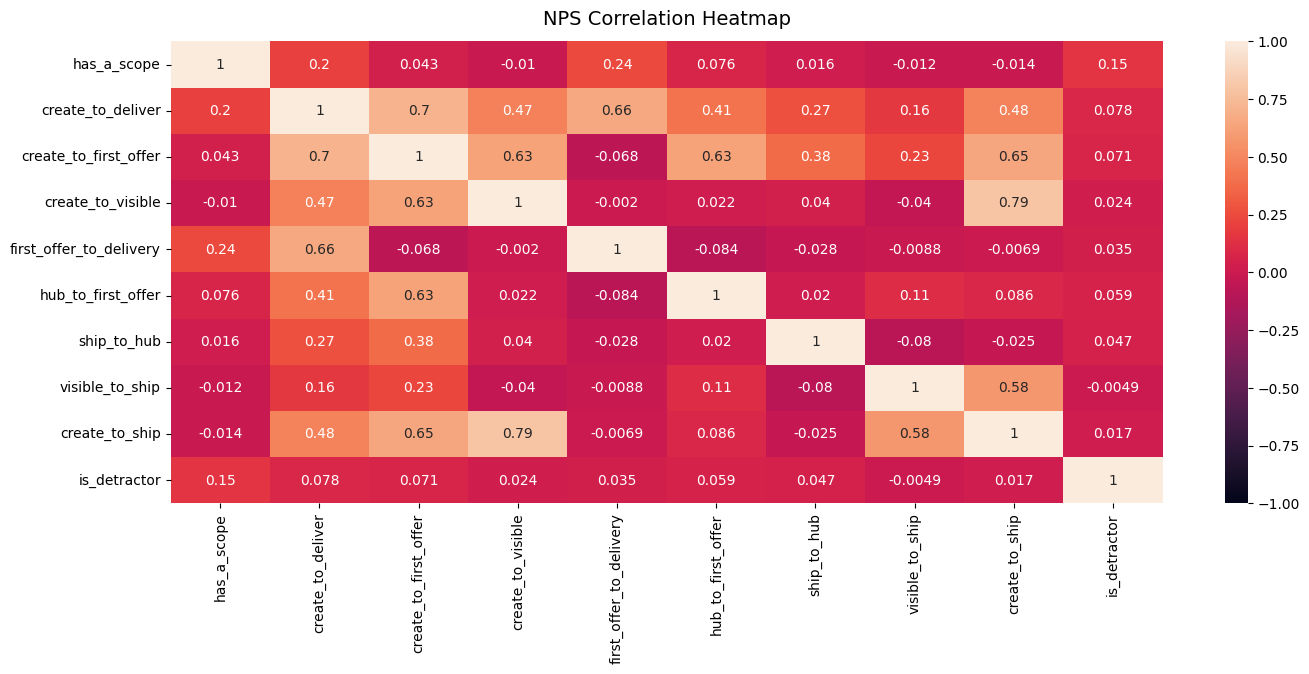

In [56]:
plt.figure("correlation heat map",figsize=(16, 6))
nps_corr_heatmap = sns.heatmap(numerical_df.corr(),vmin=-1, vmax=1, annot=True)
nps_corr_heatmap.set_title('NPS Correlation Heatmap', fontdict={'fontsize':14}, pad=12)

### ***Encoding***

One-hot was the first option, but after implementing it the dataframe resulted in 176 columns, and we don't want to overfit the model.

In [57]:
# List object columns
categorical_cols = nps_dataset.select_dtypes(include=['object']).columns

# Apply dummy encoding to each column with categorical data
encoded_df = pd.get_dummies(nps_dataset, columns=categorical_cols, drop_first=True)


In [58]:
encoded_df

,has_a_scope,delivery_weekday,delivery_month,create_to_deliver,create_to_first_offer,create_to_visible,first_offer_to_delivery,hub_to_first_offer,ship_to_hub,visible_to_ship,...,sales_channel_Costco,sales_channel_Direct to Consumer,sales_channel_Exchange,sales_channel_Other,sales_channel_Resident Home,sales_channel_S&F.com,sales_channel_Sam's,sales_channel_Sealy.com,sales_channel_TRS,sales_channel_Wayfair
0,0,2,8,19.666667,9.583333,1.541667,10.083333,3.041667,0.791667,4.208333,...,False,False,False,False,False,False,False,False,True,False
1,1,4,3,15.541667,8.541667,6.791667,7.000000,1.208333,0.250000,0.291667,...,False,False,False,False,False,False,False,False,False,False
2,0,4,3,10.458333,5.541667,3.666667,4.916667,1.125000,0.166667,0.583333,...,False,False,False,False,False,False,False,False,False,False
3,0,4,12,22.291667,7.500000,3.708333,14.791667,1.083333,0.208333,2.500000,...,False,False,False,False,False,True,False,False,False,False
4,0,4,12,29.416667,22.583333,14.916667,6.833333,7.041667,0.041667,0.583333,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16674,0,6,8,18.416667,11.583333,0.708333,6.833333,7.083333,3.125000,0.666667,...,False,True,False,False,False,False,False,False,False,False
16675,0,6,10,8.583333,8.583333,0.708333,0.000000,3.041667,3.625000,1.208333,...,False,True,False,False,False,False,False,False,False,False
16676,0,3,5,7.708333,7.500000,0.708333,0.208333,5.125000,0.916667,0.750000,...,False,True,False,False,False,False,False,False,False,False
16678,0,6,3,22.583333,22.541667,0.708333,0.041667,17.166667,3.916667,0.750000,...,False,True,False,False,False,False,False,False,False,False


### ***Balancing***

In [59]:
# we can see that there are a lot of non-detractors compared with detractors, so this means the classes are highly unbalanced.
# Indeed:
detractors = nps_dataset["is_detractor"].sum()
non_detractors = (nps_dataset["is_detractor"]==False).sum()
total = detractors+non_detractors
print(f'Detractors: \t\t {detractors} \t  {detractors/total*100:.2f} %')
print(f'Non-detractors: \t{non_detractors} \t  {non_detractors/total*100:.2f} %')
print(f'Total: \t\t\t{total} \t {total/total*100:.2f} %')


Detractors: 		 2255 	  13.90 %
Non-detractors: 	13970 	  86.10 %
Total: 			16225 	 100.00 %


# Predictive modeling
We need to **figure out the likelihood of a customer having a lower nps score (i.e., being a detractor)** to have actionable insights from this metric. We are interested in whether or not a customer is a probable detractor, regardless of the magnitude of the nps score, so **this is a binary classification problem**.

## ***Dummy-encoding***

### ***Dataset splitting***

In [143]:
# split into train and test sets
from sklearn.model_selection import train_test_split

# Numerical features
X = encoded_df.drop(columns=["is_detractor"])
y = encoded_df["is_detractor"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [144]:
print("\t\t TRAIN-TEST Size")
print("Training set size: \t\t", X_train.shape)    
print("Validation set size: \t\t", X_val.shape)    
print("Test set size: \t\t\t", X_test.shape)    
print("Training set labels size: \t", y_train.shape)    
print("Validation set labels size: \t", y_val.shape)    
print("Test set labels size: \t\t", y_test.shape)   

		 TRAIN-TEST Size
Training set size: 		 (11032, 170)
Validation set size: 		 (2759, 170)
Test set size: 			 (2434, 170)
Training set labels size: 	 (11032,)
Validation set labels size: 	 (2759,)
Test set labels size: 		 (2434,)


In [145]:
# Class proportions
detractors_training_set=(y_train==1).sum()
non_detractors_training_set=(y_train==0).sum()
detractors_validation_set=(y_val==1).sum()
non_detractors_validation_set=(y_val==0).sum()
detractors_test_set=(y_test==1).sum()
non_detractors_test_set=(y_test==0).sum()
print("\t\t\t CLASS PROPORTIONS")
print("TRAINING SET:")
print("\tPositive class (detractors):\t ", detractors_training_set, "\t {:.2f} %".format(detractors_training_set/len(y_train)*100))    
print("\tNegative class (non-detractors):", non_detractors_training_set, "\t {:.2f} %".format(non_detractors_training_set/len(y_train)*100))    
print("\t\t\t\ttotals: ",X_train.shape[0], " 100.00 %")
print("VALIDATION SET:")
print("\tPositive class (detractors):\t ", detractors_validation_set, "\t {:.2f} %".format(detractors_validation_set/len(y_val)*100))    
print("\tNegative class (non-detractors):", non_detractors_validation_set, "\t {:.2f} %".format(non_detractors_validation_set/len(y_val)*100))    
print("\t\t\t\ttotals: ",X_val.shape[0], " 100.00 %")
print("\nTEST SET:")
print("\tPositive class (detractors):\t ", detractors_test_set, "\t{:.2f} %".format(detractors_test_set/len(y_test)*100))    
print("\tNegative class (non-detractors):", non_detractors_test_set, "\t{:.2f} %".format(non_detractors_test_set/len(y_test)*100)) 
print("\t\t\t\ttotals: ",X_test.shape[0], " 100.00 %")

			 CLASS PROPORTIONS
TRAINING SET:
	Positive class (detractors):	  1513 	 13.71 %
	Negative class (non-detractors): 9519 	 86.29 %
				totals:  11032  100.00 %
VALIDATION SET:
	Positive class (detractors):	  404 	 14.64 %
	Negative class (non-detractors): 2355 	 85.36 %
				totals:  2759  100.00 %

TEST SET:
	Positive class (detractors):	  338 	13.89 %
	Negative class (non-detractors): 2096 	86.11 %
				totals:  2434  100.00 %


### ***XGBoost***

In [146]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='binary:logistic')

In [147]:
xgb_model.fit(X_train, y_train, verbose=False, early_stopping_rounds=15, eval_metric='aucpr', eval_set=[(X_val, y_val)])

c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [148]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Print the accuracy, precision, recall and f1 score
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_val, xgb_model.predict(X_val))*100))

XGBoost model accuracy: 84.85 %
XGBoost model precision: 31.58 %
XGBoost model recall: 2.97 %
XGBoost model f1 score: 5.43 %


##### ***Plot confusion matrix for validation dataset***

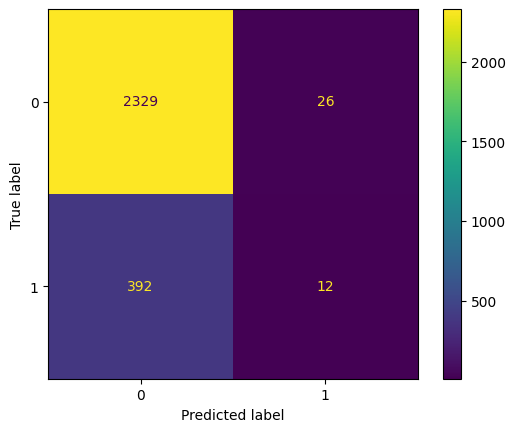

In [149]:
# import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predict on validation set
xgb_pred = xgb_model.predict(X_val)
xgb_cm = confusion_matrix(y_val, xgb_pred, labels=xgb_model.classes_)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=xgb_model.classes_)
xgb_disp.plot()

In [150]:
# Print the accuracy, precision, recall and f1 score
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_test, xgb_model.predict(X_test))*100))

XGBoost model accuracy: 85.74 %
XGBoost model precision: 34.48 %
XGBoost model recall: 2.96 %
XGBoost model f1 score: 5.45 %


## ***Numerical-only features***

### ***Dataset splitting***

In [110]:
# split into train and test sets
from sklearn.model_selection import train_test_split

# Numerical features
X = numerical_df.drop(columns=["is_detractor"])
y = numerical_df["is_detractor"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [111]:
print("\t\t TRAIN-TEST Size")
print("Training set size: \t\t", X_train.shape)    
print("Validation set size: \t\t", X_val.shape)    
print("Test set size: \t\t\t", X_test.shape)    
print("Training set labels size: \t", y_train.shape)    
print("Validation set labels size: \t", y_val.shape)    
print("Test set labels size: \t\t", y_test.shape)   

		 TRAIN-TEST Size
Training set size: 		 (11032, 9)
Validation set size: 		 (2759, 9)
Test set size: 			 (2434, 9)
Training set labels size: 	 (11032,)
Validation set labels size: 	 (2759,)
Test set labels size: 		 (2434,)


In [112]:
# Class proportions
detractors_training_set=(y_train==1).sum()
non_detractors_training_set=(y_train==0).sum()
detractors_validation_set=(y_val==1).sum()
non_detractors_validation_set=(y_val==0).sum()
detractors_test_set=(y_test==1).sum()
non_detractors_test_set=(y_test==0).sum()
print("\t\t\t CLASS PROPORTIONS")
print("TRAINING SET:")
print("\tPositive class (detractors):\t ", detractors_training_set, "\t {:.2f} %".format(detractors_training_set/len(y_train)*100))    
print("\tNegative class (non-detractors):", non_detractors_training_set, "\t {:.2f} %".format(non_detractors_training_set/len(y_train)*100))    
print("\t\t\t\ttotals: ",X_train.shape[0], " 100.00 %")
print("VALIDATION SET:")
print("\tPositive class (detractors):\t ", detractors_validation_set, "\t {:.2f} %".format(detractors_validation_set/len(y_val)*100))    
print("\tNegative class (non-detractors):", non_detractors_validation_set, "\t {:.2f} %".format(non_detractors_validation_set/len(y_val)*100))    
print("\t\t\t\ttotals: ",X_val.shape[0], " 100.00 %")
print("\nTEST SET:")
print("\tPositive class (detractors):\t ", detractors_test_set, "\t{:.2f} %".format(detractors_test_set/len(y_test)*100))    
print("\tNegative class (non-detractors):", non_detractors_test_set, "\t{:.2f} %".format(non_detractors_test_set/len(y_test)*100)) 
print("\t\t\t\ttotals: ",X_test.shape[0], " 100.00 %")

			 CLASS PROPORTIONS
TRAINING SET:
	Positive class (detractors):	  1544 	 14.00 %
	Negative class (non-detractors): 9488 	 86.00 %
				totals:  11032  100.00 %
VALIDATION SET:
	Positive class (detractors):	  391 	 14.17 %
	Negative class (non-detractors): 2368 	 85.83 %
				totals:  2759  100.00 %

TEST SET:
	Positive class (detractors):	  320 	13.15 %
	Negative class (non-detractors): 2114 	86.85 %
				totals:  2434  100.00 %


### ***XGBoost model***

In [113]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='binary:logistic')

In [114]:
xgb_model.fit(X_train, y_train, verbose=False, early_stopping_rounds=15, eval_metric='aucpr', eval_set=[(X_val, y_val)])

c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [115]:
# Print the accuracy, precision, recall and f1 score
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_val, xgb_model.predict(X_val))*100))


XGBoost model accuracy: 85.61 %
XGBoost model precision: 31.25 %
XGBoost model recall: 1.28 %
XGBoost model f1 score: 2.46 %


##### ***Plot confusion matrix for validation dataset***

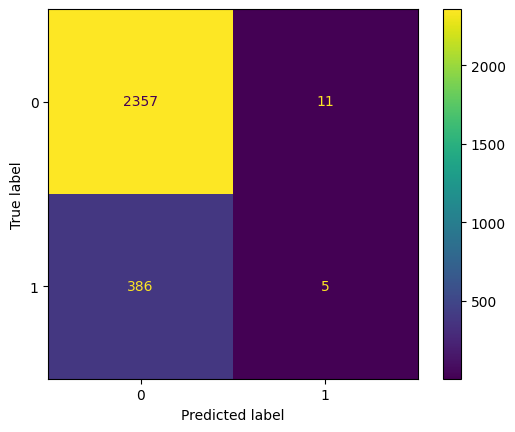

In [116]:
# import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predict on validation set
xgb_pred = xgb_model.predict(X_val)
xgb_cm = confusion_matrix(y_val, xgb_pred, labels=xgb_model.classes_)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=xgb_model.classes_)
xgb_disp.plot()

### *Parameter tuning*

In [75]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV

##### ***Set parameters for grid***

In [117]:
param_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [0],
    'reg_lambda': [0],
    'scale_pos_weight': [1, 3, 5],
    'n_estimators': [100, 500, 1000],
}

optimal_params = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', subsample=0.9),
                                param_grid=param_grid, scoring='f1', verbose=0, n_jobs=10, cv=3)

optimal_params.fit(X_train, y_train,
                early_stopping_rounds=20, 
                eval_metric='aucpr', 
                eval_set=[(X_val, y_val)],
                verbose=False)

# Print the optimal parameters
print(optimal_params.best_params_)


{'gamma': 0, 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 0, 'scale_pos_weight': 5}


c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [118]:
xgb_model = XGBClassifier(objective='binary:logistic',
                    max_depth=5,
                    learning_rate=1,
                    gamma=0,
                    reg_lambda=0,
                    scale_pos_weight=5,
                    n_estimators=100,
                )

xgb_model.fit(X_train, 
            y_train,
            verbose=False,
            early_stopping_rounds=20,
            eval_metric='aucpr',
            eval_set=[(X_val, y_val)])

c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [119]:
# Print the accuracy, precision, recall and f1 score
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_val, xgb_model.predict(X_val))*100))

XGBoost model accuracy: 76.77 %
XGBoost model precision: 24.07 %
XGBoost model recall: 29.67 %
XGBoost model f1 score: 26.58 %


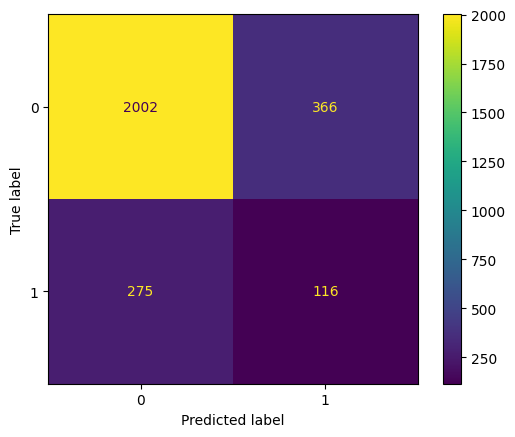

In [120]:
# predict on validation set
xgb_pred = xgb_model.predict(X_val)
xgb_cm = confusion_matrix(y_val, xgb_pred, labels=xgb_model.classes_)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=xgb_model.classes_)
xgb_disp.plot()

In [121]:
# Print the accuracy, precision, recall and f1 score
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_test, xgb_model.predict(X_test))*100))

XGBoost model accuracy: 77.77 %
XGBoost model precision: 22.72 %
XGBoost model recall: 28.75 %
XGBoost model f1 score: 25.38 %


## ***Numerical-only features - Balanced data***

In [122]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Class proportions
detractors=(y_res==1).sum()
print("Positive class (detractors):\t ", detractors, "\t {:.2f} %".format(detractors/len(y_res)*100))
non_detractors=(y_res==0).sum()
print("Negative class (non-detractors):", non_detractors, "\t {:.2f} %".format(non_detractors/len(y_res)*100))


Positive class (detractors):	  2255 	 50.00 %
Negative class (non-detractors): 2255 	 50.00 %


In [174]:
# split into train and test sets
from sklearn.model_selection import train_test_split

# Numerical features
X = X_res
y = y_res

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [175]:
# Class proportions
detractors_training_set=(y_train==1).sum()
non_detractors_training_set=(y_train==0).sum()
detractors_validation_set=(y_val==1).sum()
non_detractors_validation_set=(y_val==0).sum()
detractors_test_set=(y_test==1).sum()
non_detractors_test_set=(y_test==0).sum()
print("\t\t\t CLASS PROPORTIONS")
print("TRAINING SET:")
print("\tPositive class (detractors):\t ", detractors_training_set, "\t {:.2f} %".format(detractors_training_set/len(y_train)*100))    
print("\tNegative class (non-detractors):", non_detractors_training_set, "\t {:.2f} %".format(non_detractors_training_set/len(y_train)*100))    
print("\t\t\t\ttotals: ",X_train.shape[0], " 100.00 %")
print("VALIDATION SET:")
print("\tPositive class (detractors):\t ", detractors_validation_set, "\t {:.2f} %".format(detractors_validation_set/len(y_val)*100))    
print("\tNegative class (non-detractors):", non_detractors_validation_set, "\t {:.2f} %".format(non_detractors_validation_set/len(y_val)*100))    
print("\t\t\t\ttotals: ",X_val.shape[0], " 100.00 %")
print("\nTEST SET:")
print("\tPositive class (detractors):\t ", detractors_test_set, "\t{:.2f} %".format(detractors_test_set/len(y_test)*100))    
print("\tNegative class (non-detractors):", non_detractors_test_set, "\t{:.2f} %".format(non_detractors_test_set/len(y_test)*100)) 
print("\t\t\t\ttotals: ",X_test.shape[0], " 100.00 %")

			 CLASS PROPORTIONS
TRAINING SET:
	Positive class (detractors):	  1515 	 49.41 %
	Negative class (non-detractors): 1551 	 50.59 %
				totals:  3066  100.00 %
VALIDATION SET:
	Positive class (detractors):	  397 	 51.76 %
	Negative class (non-detractors): 370 	 48.24 %
				totals:  767  100.00 %

TEST SET:
	Positive class (detractors):	  343 	50.66 %
	Negative class (non-detractors): 334 	49.34 %
				totals:  677  100.00 %


##### ***Set parameters for grid***

In [176]:
param_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [0],
    'reg_lambda': [0],
    'scale_pos_weight': [1, 3, 5],
    'n_estimators': [100, 500, 1000],
}

optimal_params = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', subsample=0.9),
                                param_grid=param_grid, scoring='f1', verbose=0, n_jobs=10, cv=3)

optimal_params.fit(X_train, y_train,
                early_stopping_rounds=20, 
                eval_metric='aucpr', 
                eval_set=[(X_val, y_val)],
                verbose=False)

# Print the optimal parameters
print(optimal_params.best_params_)


c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 0, 'scale_pos_weight': 5}


In [177]:
xgb_model = XGBClassifier(objective='binary:logistic',
                    max_depth=5,
                    learning_rate=0.1,
                    gamma=0,
                    reg_lambda=0,
                    scale_pos_weight=5,
                    n_estimators=100,
                )

xgb_model.fit(X_train, 
            y_train,
            verbose=False,
            early_stopping_rounds=20,
            eval_metric='aucpr',
            eval_set=[(X_val, y_val)])

c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [178]:
# Print the accuracy, precision, recall and f1 score
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_val, xgb_model.predict(X_val))*100))

XGBoost model accuracy: 52.67 %
XGBoost model precision: 52.27 %
XGBoost model recall: 98.49 %
XGBoost model f1 score: 68.30 %


In [180]:
# Print the accuracy, precision, recall and f1 score for test set
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_test, xgb_model.predict(X_test))*100))

XGBoost model accuracy: 51.40 %
XGBoost model precision: 51.06 %
XGBoost model recall: 98.54 %
XGBoost model f1 score: 67.26 %


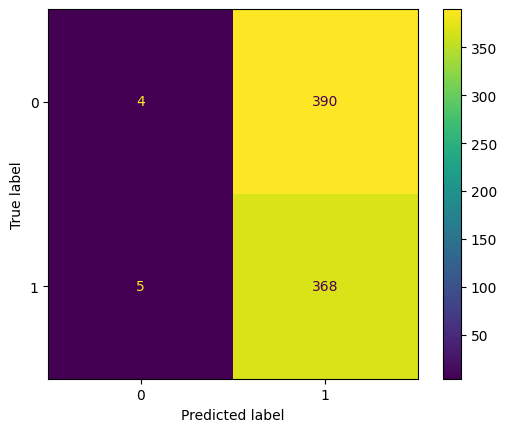

In [129]:
# predict on validation set
xgb_pred = xgb_model.predict(X_val)
xgb_cm = confusion_matrix(y_val, xgb_pred, labels=xgb_model.classes_)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=xgb_model.classes_)
xgb_disp.plot()

In [130]:
# Print the accuracy, precision, recall and f1 score
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_test, xgb_model.predict(X_test))*100))

XGBoost model accuracy: 51.11 %
XGBoost model precision: 51.12 %
XGBoost model recall: 98.55 %
XGBoost model f1 score: 67.32 %


### Normalizing

In [196]:
from sklearn import preprocessing

num_cols = ['create_to_deliver', 'create_to_first_offer',
            'create_to_visible', 'first_offer_to_delivery', 'hub_to_first_offer',
            'ship_to_hub', 'visible_to_ship', 'create_to_ship']

norm_df = numerical_df.copy()

for col in num_cols:
    tmp = np.array(numerical_df[col])
    tmp = preprocessing.normalize([tmp])
    norm_df[col] = tmp[0]


In [199]:
# split into train and test sets
from sklearn.model_selection import train_test_split

# Numerical features
X = norm_df.drop(columns=["is_detractor"])
y = norm_df["is_detractor"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [200]:
print("\t\t TRAIN-TEST Size")
print("Training set size: \t\t", X_train.shape)    
print("Validation set size: \t\t", X_val.shape)    
print("Test set size: \t\t\t", X_test.shape)    
print("Training set labels size: \t", y_train.shape)    
print("Validation set labels size: \t", y_val.shape)    
print("Test set labels size: \t\t", y_test.shape)   

		 TRAIN-TEST Size
Training set size: 		 (11032, 9)
Validation set size: 		 (2759, 9)
Test set size: 			 (2434, 9)
Training set labels size: 	 (11032,)
Validation set labels size: 	 (2759,)
Test set labels size: 		 (2434,)


In [201]:
# Class proportions
detractors_training_set=(y_train==1).sum()
non_detractors_training_set=(y_train==0).sum()
detractors_validation_set=(y_val==1).sum()
non_detractors_validation_set=(y_val==0).sum()
detractors_test_set=(y_test==1).sum()
non_detractors_test_set=(y_test==0).sum()
print("\t\t\t CLASS PROPORTIONS")
print("TRAINING SET:")
print("\tPositive class (detractors):\t ", detractors_training_set, "\t {:.2f} %".format(detractors_training_set/len(y_train)*100))    
print("\tNegative class (non-detractors):", non_detractors_training_set, "\t {:.2f} %".format(non_detractors_training_set/len(y_train)*100))    
print("\t\t\t\ttotals: ",X_train.shape[0], " 100.00 %")
print("VALIDATION SET:")
print("\tPositive class (detractors):\t ", detractors_validation_set, "\t {:.2f} %".format(detractors_validation_set/len(y_val)*100))    
print("\tNegative class (non-detractors):", non_detractors_validation_set, "\t {:.2f} %".format(non_detractors_validation_set/len(y_val)*100))    
print("\t\t\t\ttotals: ",X_val.shape[0], " 100.00 %")
print("\nTEST SET:")
print("\tPositive class (detractors):\t ", detractors_test_set, "\t{:.2f} %".format(detractors_test_set/len(y_test)*100))    
print("\tNegative class (non-detractors):", non_detractors_test_set, "\t{:.2f} %".format(non_detractors_test_set/len(y_test)*100)) 
print("\t\t\t\ttotals: ",X_test.shape[0], " 100.00 %")

			 CLASS PROPORTIONS
TRAINING SET:
	Positive class (detractors):	  1558 	 14.12 %
	Negative class (non-detractors): 9474 	 85.88 %
				totals:  11032  100.00 %
VALIDATION SET:
	Positive class (detractors):	  373 	 13.52 %
	Negative class (non-detractors): 2386 	 86.48 %
				totals:  2759  100.00 %

TEST SET:
	Positive class (detractors):	  324 	13.31 %
	Negative class (non-detractors): 2110 	86.69 %
				totals:  2434  100.00 %


In [202]:
param_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [0],
    'reg_lambda': [0],
    'scale_pos_weight': [1, 3, 5],
    'n_estimators': [100, 500, 1000],
}

optimal_params = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', subsample=0.9),
                                param_grid=param_grid, scoring='f1', verbose=0, n_jobs=10, cv=3)

optimal_params.fit(X_train, y_train,
                early_stopping_rounds=20, 
                eval_metric='aucpr', 
                eval_set=[(X_val, y_val)],
                verbose=False)

# Print the optimal parameters
print(optimal_params.best_params_)


{'gamma': 0, 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 0, 'scale_pos_weight': 5}


c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [203]:
xgb_model = XGBClassifier(objective='binary:logistic',
                    max_depth=5,
                    learning_rate=1,
                    gamma=0,
                    reg_lambda=0,
                    scale_pos_weight=5,
                    n_estimators=100,
                )

xgb_model.fit(X_train, 
            y_train,
            verbose=False,
            early_stopping_rounds=20,
            eval_metric='aucpr',
            eval_set=[(X_val, y_val)])

c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\nahim\Documents\Escuela\Profesional\10mo sem\Tesina\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [204]:
# Print the accuracy, precision, recall and f1 score
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_val, xgb_model.predict(X_val))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_val, xgb_model.predict(X_val))*100))

XGBoost model accuracy: 76.69 %
XGBoost model precision: 25.18 %
XGBoost model recall: 36.73 %
XGBoost model f1 score: 29.88 %


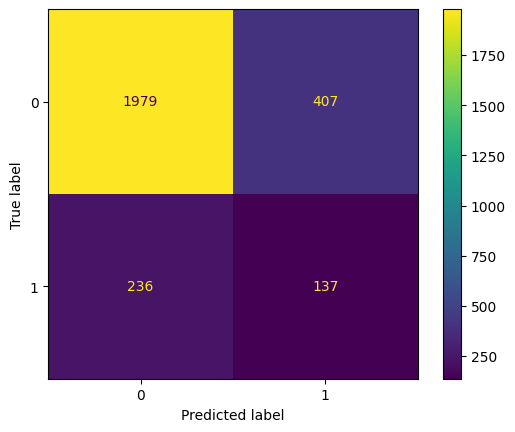

In [205]:
# predict on validation set
xgb_pred = xgb_model.predict(X_val)
xgb_cm = confusion_matrix(y_val, xgb_pred, labels=xgb_model.classes_)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=xgb_model.classes_)
xgb_disp.plot()

In [206]:
# Print the accuracy, precision, recall and f1 score
print("XGBoost model accuracy: {:.2f} %".format(accuracy_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model precision: {:.2f} %".format(precision_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model recall: {:.2f} %".format(recall_score(y_test, xgb_model.predict(X_test))*100))
print("XGBoost model f1 score: {:.2f} %".format(f1_score(y_test, xgb_model.predict(X_test))*100))

XGBoost model accuracy: 76.09 %
XGBoost model precision: 23.67 %
XGBoost model recall: 35.80 %
XGBoost model f1 score: 28.50 %


## ***Anomaly detection algorithm***

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [159]:

#define paramter for feature normalization
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

#define the parameter and estimate the Gaussian distribution
def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

#define the multivariate Gaussian distribution
def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def select_threshold(probs, test_data):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(test_data, predictions, average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon

    return best_f1, best_epsilon

In [160]:
num_df = numerical_df.copy()
numeric_cols = ['has_a_scope', 'create_to_deliver', 'create_to_first_offer',
    'create_to_visible', 'first_offer_to_delivery', 'hub_to_first_offer',
    'ship_to_hub', 'visible_to_ship', 'create_to_ship']

In [161]:

# Make columns Gaussian-like
num_df['create_to_deliver'] = np.log(num_df['create_to_deliver']+0.7)
num_df['create_to_first_offer'] = np.log(num_df['create_to_first_offer']+0.2)
num_df['create_to_visible'] = np.log(num_df['create_to_visible']-0.1)
num_df['first_offer_to_delivery'] = num_df['first_offer_to_delivery'] ** 0.35
num_df['hub_to_first_offer'] = num_df['hub_to_first_offer'] ** 0.3
num_df['ship_to_hub'] = num_df['ship_to_hub'] ** 0.2
num_df['visible_to_ship'] = num_df['visible_to_ship'] ** 0.25
num_df['create_to_ship'] = num_df['create_to_ship'] ** 0.25

# Train-CV-Test splits
neg = num_df[num_df['is_detractor'] == 0]
x_neg = neg[numeric_cols]
y_neg = neg['is_detractor']

pos = num_df[num_df['is_detractor'] == 1]
x_pos = pos[numeric_cols]
y_pos = pos['is_detractor']

# Split negative samples
x_train_neg, x_val_test_neg, y_train_neg, y_val_test_neg = train_test_split(x_neg, y_neg, train_size = 11715)
x_val_neg, x_test_neg, y_val_neg, y_test_neg = train_test_split(x_val_test_neg, y_val_test_neg, train_size = 0.5)

# Split positive samples
x_val_pos, x_test_pos, y_val_pos, y_test_pos = train_test_split(x_pos, y_pos, train_size=0.5)

x_val = pd.concat([x_val_neg, x_val_pos])
y_val = pd.concat([y_val_neg, y_val_pos])
x_test = pd.concat([x_test_neg, x_test_pos])
y_test = pd.concat([y_test_neg, y_test_pos])

In [163]:
mu, sigma = estimate_gaussian(x_train_neg)
p = multivariate_gaussian(x_train_neg, mu, sigma)

# selecting optimal value of epsilon using cross validation
p_cv = multivariate_gaussian(x_val, mu, sigma)
fscore, ep = select_threshold(p_cv, y_val)

predictions = (p_cv < ep)

In [172]:
score_df = pd.DataFrame()
score_df['y'] = y_val
score_df['prob'] = predictions

In [173]:
# Calculate the precision and recall scores using the score_df dataframe
precision = score_df[(score_df['y'] == 1) & (score_df['prob'] == 1)].shape[0] / score_df[score_df['prob'] == 1].shape[0]
recall = score_df[(score_df['y'] == 1) & (score_df['prob'] == 1)].shape[0] / score_df[score_df['y'] == 1].shape[0]

print('Precision score: {:.4f}'.format(precision))
print('Recall score: {:.4f}'.format(recall))

# Calculate the accuracy score using the score_df dataframe
accuracy = (score_df[(score_df['y'] == 1) & (score_df['prob'] == 1)].shape[0] + score_df[(score_df['y'] == 0) & (score_df['prob'] == 0)].shape[0]) / score_df.shape[0]

print('Accuracy score: {:.4f}'.format(accuracy))

# Calculate the F1 score using the precision and recall variables
f1 = 2 * (precision * recall) / (precision + recall)

print('F1 score: {:.4f}'.format(f1))

Precision score: 0.5229
Recall score: 0.9326
Accuracy score: 0.5408
F1 score: 0.6701


In [166]:
# selecting optimal value of epsilon using cross validation
p_cv = multivariate_gaussian(x_test, mu, sigma)
fscore, ep = select_threshold(p_cv, y_test)

predictions = (p_cv < ep)

In [168]:
score_df = pd.DataFrame()
score_df['y'] = y_test
score_df['prob'] = predictions

In [170]:
# Calculate the precision and recall scores using the score_df dataframe
precision = score_df[(score_df['y'] == 1) & (score_df['prob'] == 1)].shape[0] / score_df[score_df['prob'] == 1].shape[0]
recall = score_df[(score_df['y'] == 1) & (score_df['prob'] == 1)].shape[0] / score_df[score_df['y'] == 1].shape[0]

print('Precision score: {:.4f}'.format(precision))
print('Recall score: {:.4f}'.format(recall))

# Calculate the accuracy score using the score_df dataframe
accuracy = (score_df[(score_df['y'] == 1) & (score_df['prob'] == 1)].shape[0] + score_df[(score_df['y'] == 0) & (score_df['prob'] == 0)].shape[0]) / score_df.shape[0]

print('Accuracy score: {:.4f}'.format(accuracy))

# Calculate the F1 score using the precision and recall variables
f1 = 2 * (precision * recall) / (precision + recall)

print('F1 score: {:.4f}'.format(f1))

Precision score: 0.5036
Recall score: 0.9894
Accuracy score: 0.5071
F1 score: 0.6675


In [187]:
# Numerical features
X = numerical_df.drop(columns=["is_detractor"])
y = numerical_df["is_detractor"]

In [188]:
# selecting optimal value of epsilon using cross validation
p_cv = multivariate_gaussian(X, mu, sigma)
fscore, ep = select_threshold(p_cv, y)

predictions = (p_cv < ep)
score_df = pd.DataFrame()
score_df['y'] = y
score_df['prob'] = predictions

# Calculate the precision and recall scores using the score_df dataframe
precision = score_df[(score_df['y'] == 1) & (score_df['prob'] == 1)].shape[0] / score_df[score_df['prob'] == 1].shape[0]
recall = score_df[(score_df['y'] == 1) & (score_df['prob'] == 1)].shape[0] / score_df[score_df['y'] == 1].shape[0]

print('Precision score: {:.4f}'.format(precision))
print('Recall score: {:.4f}'.format(recall))

# Calculate the accuracy score using the score_df dataframe
accuracy = (score_df[(score_df['y'] == 1) & (score_df['prob'] == 1)].shape[0] + score_df[(score_df['y'] == 0) & (score_df['prob'] == 0)].shape[0]) / score_df.shape[0]

print('Accuracy score: {:.4f}'.format(accuracy))

# Calculate the F1 score using the precision and recall variables
f1 = 2 * (precision * recall) / (precision + recall)

print('F1 score: {:.4f}'.format(f1))

Precision score: 0.1389
Recall score: 0.9996
Accuracy score: 0.1390
F1 score: 0.2440
